In [ ]:
import numpy as np
import cv2
import random
import random
import copy
from scipy.spatial.transform import Rotation as R
from skimage import transform



import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
pip install scikit-surgery

ERROR: Could not find a version that satisfies the requirement sksurgerycore (from versions: none)
ERROR: No matching distribution found for sksurgerycore


In [ ]:
#Borrow some functions from Example CW

def extract_rigid_body_parameters(matrix):
    t = matrix[0:3, 3]
    r = matrix[0:3, 0:3]
    r = R.from_matrix(r)
    euler = r.as_euler('zyx', degrees=True)
    return [euler[0], euler[1], euler[2], t[0], t[1], t[2]]

def rigid_body_parameters_to_matrix(params):
    matrix = np.eye(4)
    r = (R.from_euler('zyx', [params[0], params[1], params[2]], degrees=True)).as_matrix()
    matrix[0:3, 0:3] = r
    matrix[0][3] = params[3]
    matrix[1][3] = params[4]
    matrix[2][3] = params[5]
    return matrix

def Needle_to_CT(point,point_to_detector, detector_to_CT):
  return detector_to_CT @ point_to_detector @ point

In [ ]:
def distance_from_line(p_1, p_2, p_3):
    """
    Computes distance of a point p_3, from a line defined by p_1 and p_2.

    See `here <https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line>`_.

    :return: euclidean distance
    """
    # I want notation same as wikipedia page, so disabling warning.
    # pylint: disable=invalid-name
    n = p_2 - p_1
    n = n / np.linalg.norm(n)
    a_minus_p = p_1 - p_3
    vector_to_line = a_minus_p - (np.dot(a_minus_p, n) * n)
    distance = np.linalg.norm(vector_to_line)
    return distance


def compute_tre_from_fle(fiducials, mean_fle_squared, target_point):
    """
    Computes an estimation of TRE from FLE and a list of fiducial locations.

    See:
    `Fitzpatrick (1998), equation 46 <http://dx.doi.org/10.1109/42.736021>`_.

    :param fiducials: Nx3 ndarray of fiducial points
    :param mean_fle_squared: expected (mean) FLE squared
    :param target_point: a point for which to compute TRE.
    :return: mean TRE squared
    """
    # pylint: disable=literal-comparison
    if not isinstance(fiducials, np.ndarray):
        raise TypeError("fiducials is not a numpy array'")
    if not fiducials.shape[1] == 3:
        raise ValueError("fiducials should have 3 columns")
    if fiducials.shape[0] < 3:
        raise ValueError("fiducials should have at least 3 rows")
    if not isinstance(target_point, np.ndarray):
        raise TypeError("target_point is not a numpy array'")
    if not target_point.shape[1] == 3:
        raise ValueError("target_point should have 3 columns")
    if not target_point.shape[0] == 1:
        raise ValueError("target_point should have 1 row")

    number_of_fiducials = fiducials.shape[0]
    centroid = np.mean(fiducials, axis=0)
    covariance = np.cov(fiducials.T)
    assert covariance.shape[0] == 3
    assert covariance.shape[1] == 3
    _, eigen_vectors_matrix = np.linalg.eig(covariance)

    f_array = np.zeros(3)
    for axis_index in range(3):
        sum_f_k_squared = 0
        for fiducial_index in range(fiducials.shape[0]):
            f_k = distance_from_line(centroid,
                                        eigen_vectors_matrix[axis_index],
                                        fiducials[fiducial_index])
            sum_f_k_squared = sum_f_k_squared + f_k * f_k
        f_k_rms = np.sqrt(sum_f_k_squared / number_of_fiducials)
        f_array[axis_index] = f_k_rms

    inner_sum = 0
    for axis_index in range(3):
        d_k = distance_from_line(centroid,
                                    eigen_vectors_matrix[axis_index],
                                    target_point)
        inner_sum = inner_sum + (d_k * d_k / f_array[axis_index])

    mean_tre_squared = (mean_fle_squared / fiducials.shape[0]) * \
                       (1 + (1./3.) * inner_sum)
    return mean_tre_squared

def compute_fre(fixed, moving, rotation, translation):
    """
    Computes the Fiducial Registration Error, equal
    to the root mean squared error between corresponding fiducials.

    :param fixed: point set, N x 3 ndarray
    :param moving: point set, N x 3 ndarray of corresponding points
    :param rotation: 3 x 3 ndarray
    :param translation: 3 x 1 ndarray
    :returns: Fiducial Registration Error (FRE)
    """
    # pylint: disable=assignment-from-no-return

    validate_procrustes_inputs(fixed, moving)

    transformed_moving = np.matmul(rotation, moving.transpose()) + translation
    squared_error_elementwise = np.square(fixed
                                          - transformed_moving.transpose())
    square_distance_error = np.sum(squared_error_elementwise, 1)
    sum_squared_error = np.sum(square_distance_error, 0)
    mean_squared_error = sum_squared_error / fixed.shape[0]
    fre = np.sqrt(mean_squared_error)
    return fre

def validate_procrustes_inputs(fixed, moving):
  """
  Validates the fixed and moving set of points

  1. fixed and moving must be numpy array
  2. fixed and moving should have 3 columns
  3. fixed and moving should have at least 3 rows
  4. fixed and moving should have the same number of rows

  :param fixed: point set, N x 3 ndarray
  :param moving: point set, N x 3 ndarray of corresponding points
  :returns: nothing
  :raises: TypeError, ValueError
  """
  if not isinstance(fixed, np.ndarray):
      raise TypeError("fixed is not a numpy array'")

  if not isinstance(moving, np.ndarray):
      raise TypeError("moving is not a numpy array")

  if not fixed.shape[1] == 3:  # pylint: disable=literal-comparison
      raise ValueError("fixed should have 3 columns")

  if not moving.shape[1] == 3:  # pylint: disable=literal-comparison
      raise ValueError("moving should have 3 columns")

  if fixed.shape[0] < 3:
      raise ValueError("fixed should have at least 3 points (rows)")

  if moving.shape[0] < 3:
      raise ValueError("moving should have at least 3 points (rows)")

  if not fixed.shape[0] == moving.shape[0]:
      raise ValueError("fixed and moving should have "|
                      + "the same number of points (rows)")
        


import numpy as np


# pylint: disable=invalid-name, line-too-long


def orthogonal_procrustes(fixed, moving):
    """
    Implements point based registration via the Orthogonal Procrustes method.

    Based on Arun's method:

      Least-Squares Fitting of two, 3-D Point Sets, Arun, 1987,
      `10.1109/TPAMI.1987.4767965 <http://dx.doi.org/10.1109/TPAMI.1987.4767965>`_.

    Also see `this <http://eecs.vanderbilt.edu/people/mikefitzpatrick/papers/2009_Medim_Fitzpatrick_TRE_FRE_uncorrelated_as_published.pdf>`_
    and `this <http://tango.andrew.cmu.edu/~gustavor/42431-intro-bioimaging/readings/ch8.pdf>`_.

    :param fixed: point set, N x 3 ndarray
    :param moving: point set, N x 3 ndarray of corresponding points
    :returns: 3x3 rotation ndarray, 3x1 translation ndarray, FRE
    :raises: ValueError
    """

    validate_procrustes_inputs(fixed, moving)

    # This is what we are calculating
    R = np.eye(3)
    T = np.zeros((3, 1))

    # Arun equation 4
    p = np.ndarray.mean(moving, 0)

    # Arun equation 6
    p_prime = np.ndarray.mean(fixed, 0)

    # Arun equation 7
    q = moving - p

    # Arun equation 8
    q_prime = fixed - p_prime

    # Arun equation 11
    H = np.matmul(q.transpose(), q_prime)

    # Arun equation 12
    # Note: numpy factors h = u * np.diag(s) * v
    svd = np.linalg.svd(H)

    # Replace Arun Equation 13 with Fitzpatrick, chapter 8, page 470,
    # to avoid reflections, see issue #19
    X = _fitzpatricks_X(svd)

    # Arun step 5, after equation 13.
    det_X = np.linalg.det(X)

    if det_X < 0 and np.all(np.flip(np.isclose(svd[1], np.zeros((3, 1))))):

        # Don't yet know how to generate test data.
        # If you hit this line, please report it, and save your data.
        raise ValueError("Registration fails as determinant < 0"
                         " and no singular values are close enough to zero")

    if det_X < 0 and np.any(np.isclose(svd[1], np.zeros((3, 1)))):
        # Implement 2a in section VI in Arun paper.
        v_prime = svd[2].transpose()
        v_prime[0][2] *= -1
        v_prime[1][2] *= -1
        v_prime[2][2] *= -1
        X = np.matmul(v_prime, svd[0].transpose())


    # Compute output
    R = X
    tmp = p_prime.transpose() - np.matmul(R, p.transpose())
    T[0][0] = tmp[0]
    T[1][0] = tmp[1]
    T[2][0] = tmp[2]
    fre = compute_fre(fixed, moving, R, T)

    return R, T, fre


def _fitzpatricks_X(svd):
    """This is from Fitzpatrick, chapter 8, page 470.
       it's used in preference to Arun's equation 13,
       X = np.matmul(svd[2].transpose(), svd[0].transpose())
       to avoid reflections.
    """
    VU = np.matmul(svd[2].transpose(), svd[0])
    detVU = np.linalg.det(VU)

    diag = np.eye(3, 3)
    diag[2][2] = detVU

    X = np.matmul(svd[2].transpose(), np.matmul(diag, svd[0].transpose()))
    return X
  
def construct_rigid_transformation(rot_m, trans_v):
    """Construct a 4x4 rigid-body transformation from a 3x3 rotation matrix and
    a 3x1 vector as translation

    :param rot_m: 3x3 rotation matrix, numpy array
    :param trans_v: 3x1 vector as translation, numpy array
    :returns: rigid_transformation -- 4x4 rigid transformation matrix,
    numpy array
    """
    rigid_transformation = np.identity(4)

    for i in range(3):
        for j in range(3):
            rigid_transformation[i][j] = rot_m[i][j]

    rigid_transformation[0][3] = trans_v[0]
    rigid_transformation[1][3] = trans_v[1]
    rigid_transformation[2][3] = trans_v[2]

    return rigid_transformation

In [ ]:
#Load in some transformation matricies
detector_to_CT = np.loadtxt('/content/drive/My Drive/SimulationData/Detector_to_CT.txt')
point_to_detector = np.loadtxt('/content/drive/My Drive/SimulationData/needle_detector.txt')

#Get rigid body params
detector2CT = extract_rigid_body_parameters(detector_to_CT)
point2detector = extract_rigid_body_parameters(point_to_detector)



In [ ]:
def define_gold_standard(x,y,z):
  point = np.zeros((4,1)) 
  
  point[0][0] = x
  point[1][0] = y
  point[2][0] = z
  point[3][0] = 1

  point_in_CT = Needle_to_CT(point, point_to_detector, detector_to_CT)
  return point, point_in_CT
 

  
  

In [ ]:
#Set a gold standard position
needle, gold_standard_point_in_CT = define_gold_standard(5,15,-10)

##Experiment 1 - Effect of Noise on Translation Transforms
Applying random gaussian noise to simulate random effects such as field distortions which may occur during the procedure

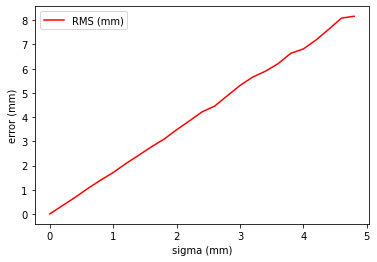

In [ ]:
number_samples = 1000
x_values = []
y_values = []

for sigma_counter in range(0,25,1):
  sigma = sigma_counter /5
  rms = 0
  for i in range(number_samples):
    temp_point2detector = copy.deepcopy(point2detector)
    temp_point2detector[3] = temp_point2detector[3] + random.normalvariate(0,sigma)
    temp_point2detector[4] = temp_point2detector[4] + random.normalvariate(0,sigma)
    temp_point2detector[5] = temp_point2detector[5] + random.normalvariate(0,sigma)
    temp_point2detector_mat = rigid_body_parameters_to_matrix(temp_point2detector)

    translated_world_point = detector_to_CT @ temp_point2detector_mat @ needle

    diff = np.linalg.norm(gold_standard_point_in_CT - translated_world_point)
    diff = diff* diff
    rms = rms + diff
  rms = rms / number_samples
  rms = np.sqrt(rms)

  x_values.append(sigma)
  y_values.append(rms)

plt.plot(x_values, y_values, 'r', label='RMS (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (mm)')
plt.ylabel('error (mm)')
plt.show()


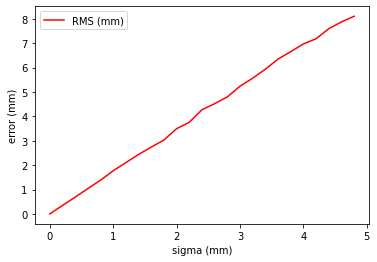

In [ ]:
number_samples = 1000
x_values = []
y_values = []

for sigma_counter in range(0,25,1):
  sigma = sigma_counter /5
  rms = 0
  for i in range(number_samples):
    temp_detector2CT = copy.deepcopy(detector2CT)
    temp_detector2CT[3] = temp_detector2CT[3] + random.normalvariate(0,sigma)
    temp_detector2CT[4] = temp_detector2CT[4] + random.normalvariate(0,sigma)
    temp_detector2CT[5] = temp_detector2CT[5] + random.normalvariate(0,sigma)
    temp_detector2CT_mat = rigid_body_parameters_to_matrix(temp_detector2CT)

    translated_world_point = temp_detector2CT_mat @ point_to_detector @ needle

    diff = np.linalg.norm(gold_standard_point_in_CT - translated_world_point)
    diff = diff* diff
    rms = rms + diff
  rms = rms / number_samples
  rms = np.sqrt(rms)

  x_values.append(sigma)
  y_values.append(rms)

plt.plot(x_values, y_values, 'r', label='RMS (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (mm)')
plt.ylabel('error (mm)')
plt.show()

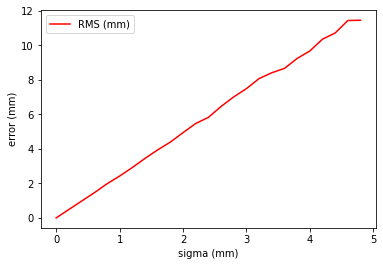

In [ ]:
number_samples = 1000
x_values = []
y_values = []

for sigma_counter in range(0,25,1):
  sigma = sigma_counter /5
  rms = 0
  for i in range(number_samples):
    temp_detector2CT = copy.deepcopy(detector2CT)
    temp_detector2CT[3] = temp_detector2CT[3] + random.normalvariate(0,sigma)
    temp_detector2CT[4] = temp_detector2CT[4] + random.normalvariate(0,sigma)
    temp_detector2CT[5] = temp_detector2CT[5] + random.normalvariate(0,sigma)
    temp_detector2CT_mat = rigid_body_parameters_to_matrix(temp_detector2CT)

    temp_point2detector = copy.deepcopy(point2detector)
    temp_point2detector[3] = temp_point2detector[3] + random.normalvariate(0,sigma)
    temp_point2detector[4] = temp_point2detector[4] + random.normalvariate(0,sigma)
    temp_point2detector[5] = temp_point2detector[5] + random.normalvariate(0,sigma)
    temp_point2detector_mat = rigid_body_parameters_to_matrix(temp_point2detector)

    translated_world_point = temp_detector2CT_mat @ temp_point2detector_mat @ needle

    diff = np.linalg.norm(gold_standard_point_in_CT - translated_world_point)
    diff = diff* diff
    rms = rms + diff
  rms = rms / number_samples
  rms = np.sqrt(rms)

  x_values.append(sigma)
  y_values.append(rms)

plt.plot(x_values, y_values, 'r', label='RMS (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (mm)')
plt.ylabel('error (mm)')
plt.show()

##Experiment 2 - Does Translational noise or Rotational Noise increase Error?
Add random gaussian noise to the x coordinate and rotation around the x-axis

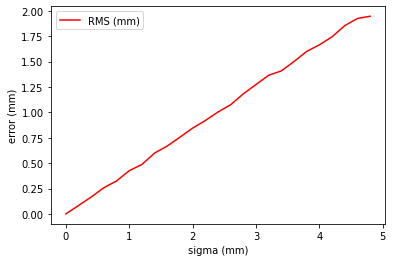

In [ ]:
number_samples = 1000
x_values = []
y_values = []

for sigma_counter in range(0,25,1):
  sigma = sigma_counter /5
  rms = 0
  for i in range(number_samples):
    temp_point2detector = copy.deepcopy(point2detector)
    temp_point2detector[0] = temp_point2detector[0] + random.normalvariate(0,sigma)
    temp_point2detector[2] = temp_point2detector[2] + random.normalvariate(0,sigma)
    temp_point2detector_mat = rigid_body_parameters_to_matrix(temp_point2detector)

    translated_world_point = detector_to_CT @ temp_point2detector_mat @ needle
    #print(translated_world_point)

    diff = np.linalg.norm(gold_standard_point_in_CT - translated_world_point)
    diff = diff* diff
    rms = rms + diff
  rms = rms / number_samples
  rms = np.sqrt(rms)

  x_values.append(sigma)
  y_values.append(rms)

plt.plot(x_values, y_values, 'r', label='RMS (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (mm)')
plt.ylabel('error (mm)')
plt.show()

1-D translations V 1dof rotation


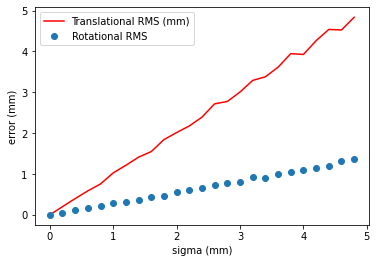

In [ ]:
number_samples = 1000
x_values = []
trans_values = []

for sigma_counter in range(0,25,1):
  sigma = sigma_counter /5
  rms = 0
  for i in range(number_samples):
    temp_point2detector = copy.deepcopy(point2detector)
    temp_point2detector[3] = temp_point2detector[3] + random.normalvariate(0,sigma)
    # temp_point2detector[4] = temp_point2detector[4] + random.normalvariate(0,sigma)
    # temp_point2detector[5] = temp_point2detector[5] + random.normalvariate(0,sigma)
    temp_point2detector_mat = rigid_body_parameters_to_matrix(temp_point2detector)

    translated_world_point = detector_to_CT @ temp_point2detector_mat @ needle

    diff = np.linalg.norm(gold_standard_point_in_CT - translated_world_point)
    diff = diff* diff
    rms = rms + diff
  rms = rms / number_samples
  rms = np.sqrt(rms)

  x_values.append(sigma)
  trans_values.append(rms)

rot_values = []
x2_values = []

for sigma_counter in range(0,25,1):
  sigma = sigma_counter /5
  rms = 0
  for i in range(number_samples):
    temp_point2detector = copy.deepcopy(point2detector)
    temp_point2detector[0] = temp_point2detector[0] + random.normalvariate(0,sigma)
    # temp_point2detector[1] = temp_point2detector[1] + random.normalvariate(0,sigma)
    # temp_point2detector[2] = temp_point2detector[2] + random.normalvariate(0,sigma)
    temp_point2detector_mat = rigid_body_parameters_to_matrix(temp_point2detector)

    translated_world_point = detector_to_CT @ temp_point2detector_mat @ needle
    #print(translated_world_point)

    diff = np.linalg.norm(gold_standard_point_in_CT - translated_world_point)
    diff = diff* diff
    rms = rms + diff
  rms = rms / number_samples
  rms = np.sqrt(rms)

  x2_values.append(sigma)
  rot_values.append(rms)

plt.plot(x_values, trans_values, 'r', label='Translational RMS (mm)')
plt.plot(x2_values, rot_values, 'o', label = 'Rotational RMS')
plt.legend(loc='upper left')
plt.xlabel('sigma (mm)')
plt.ylabel('error (mm)')
plt.show()

TRE

##Experiment 3 - Investigating the impact of position of fiducials on TRE
Random points are used as fiducial locations and the TRE calculated in order to determine whether an untrained person could do the setup

In [ ]:
fiducials_loc = np.ones((7,3))

In [ ]:
fiducials_loc[0][0] = 150
fiducials_loc[0][1] = 10
fiducials_loc[0][2] = 100
fiducials_loc[1][0] = -150
fiducials_loc[1][1] = 10
fiducials_loc[1][2] = -10
fiducials_loc[2][0] = 36
fiducials_loc[2][1] = 150
fiducials_loc[2][2] = 45
fiducials_loc[3][0] = 60
fiducials_loc[3][1] = 5
fiducials_loc[3][2] = 100
fiducials_loc[4][0] = 150
fiducials_loc[4][1] = 0
fiducials_loc[4][2] = 0
fiducials_loc[5][0] = 25
fiducials_loc[5][1] = 0
fiducials_loc[5][2] = 100
fiducials_loc[6][0] = -50
fiducials_loc[6][1] = 15
fiducials_loc[6][2] = 50


In [ ]:
target = np.ones((1,3))
target[0][0] = 35
target[0][1] = -15
target[0][2] = 45

In [ ]:
compute_tre_from_fle(fiducials_loc,1.6**2, target)

5.459300368075579

In [ ]:
fiducials_with_needle = np.zeros((8,3))
fiducials_with_needle[:7] = fiducials_loc
fiducials_with_needle[7][0] = 40
fiducials_with_needle[7][1] = -25
fiducials_with_needle[7][2] = 0 


In [ ]:
compute_tre_from_fle(fiducials_with_needle, 1.6**2, target)

4.295788454876894

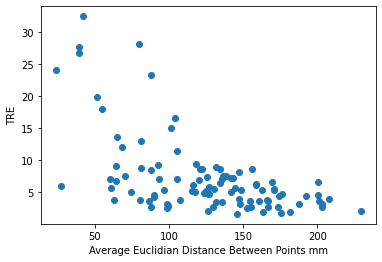

In [ ]:
TRE = []
Distance = []
for x in range(100):
  fiducial_locations = np.zeros((7,3))
  for i in range(6):
    fiducial_locations[i][0] = random.randint(-230,230)
    fiducial_locations[i][1] = random.randint(0,30)
    fiducial_locations[i][2] = random.randint(0,300)
  tre = compute_tre_from_fle(fiducial_locations, 1.6**2, target)
  x_mean = np.mean(fiducial_locations[:][0])
  y_mean = np.mean(fiducial_locations[:][1])
  z_mean = np.mean(fiducial_locations[:][2])
  distance = (x_mean**2 + y_mean**2 + z_mean**2)**0.5
  TRE.append(tre)
  Distance.append(distance)

plt.scatter(Distance,TRE)
plt.xlabel('Average Euclidian Distance Between Points mm')
plt.ylabel('TRE')
plt.show()



#Experiment 4
Adding increasing numbers of randomly placed needles to be used as internal fiducial locations

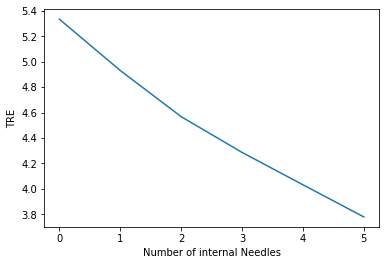

In [ ]:
sample = 10000
TRE = []
Num_of_needle = []
for x in range(6):
  registration_er = 0
  for k in range(sample):
    fiducial_locations = np.zeros((7 + x ,3))
    for i in range(len((fiducial_locations))):
      fiducial_locations[i][0] = random.randint(-230,230)
      fiducial_locations[i][1] = random.randint(0,30)
      fiducial_locations[i][2] = random.randint(0,500)
      if i > 6:
        fiducial_locations[i][0] = random.randint(-50,50)
        fiducial_locations[i][1] = random.randint(-20,0)
        fiducial_locations[i][2] = random.randint(0,30)

    y = compute_tre_from_fle(fiducial_locations, 1.6**2, target)
    # print(y)
    registration_er += y/sample
  # print(registration_er)
  tre = registration_er
  TRE.append(tre)
  Num_of_needle.append(x)

plt.plot(Num_of_needle,TRE)
plt.xlabel('Number of internal Needles')
plt.ylabel('TRE')
plt.show()

###This went wrong

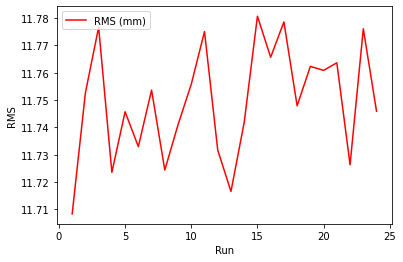

In [ ]:
x_values = []
y_values = []
number_samples = 1000

for sigma_counter in range(1,25,1):
  
  sigma = 0.25
  rms = 0
 
  temp_target = copy.deepcopy(target)
  new_dim = [1]
  temp_target = np.append(temp_target, new_dim)
  temp_target[0] = temp_target[0] + random.gauss(0, sigma)
  temp_target[1] = temp_target[1] + random.gauss(0, sigma)
  temp_target[2] = temp_target[2] + random.gauss(0, sigma)
      
  for j in range(number_samples):
    temp_fiducials_loc = copy.deepcopy(fiducials_loc)
    for i in range(len(fiducials_loc)):
      temp_fiducials_loc[i][0] = temp_fiducials_loc[i][0] + random.gauss(0, sigma)
      temp_fiducials_loc[i][1] = temp_fiducials_loc[i][1] + random.gauss(0, sigma)
      temp_fiducials_loc[i][2] = temp_fiducials_loc[i][2] + random.gauss(0, sigma)


    rot_mat, trans_mat, FRE = orthogonal_procrustes(temp_fiducials_loc, fiducials_loc)

    matrix = construct_rigid_transformation(rot_mat, trans_mat)

    new_target = matrix @ temp_target.reshape(4,1)

    diff = np.linalg.norm(new_target - temp_target)

    diff = diff * diff
    diff = np.sqrt(diff)
    rms = rms + diff
  rms = rms /number_samples
  rms = np.sqrt(rms)

  x_values.append(sigma_counter)
  y_values.append(rms)

plt.plot(x_values, y_values, 'r', label='RMS (mm)')
plt.legend(loc='upper left')
plt.xlabel('Run')
plt.ylabel('RMS')
plt.show()





In [ ]:
rms_array = np.array(y_values)

In [ ]:
(rms_array.mean()) * (3**0.5)

20.350718231281814

In [ ]:
rot_mat, trans_mat, FRE = orthogonal_procrustes(fiducials_loc,temp_fiducials_loc )

In [ ]:
matrix = construct_rigid_transformation(rot_mat, trans_mat)